#########################################
### Alunos: Alaf Santos e João Macedo ###
#########################################

```
Fazer a reconstrução 3D da caixa fotografada nas duas imagens:
- Calcular e mostrar o mapa de disparidade entre as imagens retificadas
- Realizar a reconstrução da profundidade Z, usando o método de reconstrução com imagens retificadas visto na Aula 11. 
  A seguir, realizar a reconstrução das coordenadas X e Y.
- Plotar a reconstrução colorindo cada ponto reconstruído com a cor de seu pixel correspondente. 
```

In [22]:
#Instalando e importando dependências 
!pip install imgaug==0.2.5
!pip install opencv-python==3.4.2.17 opencv-contrib-python==3.4.2.17

import numpy as np
import cv2 as cv
import sys
import imutils
import random

from matplotlib import pyplot as plt
from scipy.optimize import minimize, root, least_squares
from scipy import ndimage, misc
from mpl_toolkits.mplot3d import Axes3D

# **Definições de Funções**



In [23]:
def obtain_correspondent_points(left_img, right_img, threshold: float = 0.5, show_matches: bool = False):
    """
    Obtém os pontos de correspondência entre duas imagens.
    :param left_img: Imagem capturada pela câmera esquerda.
    :param right_img: Imagem capturada pela câmera direita.
    :param threshold: float Limiar utilizado na aquisição dos pontos de correspondência. Default: 0.5.
    :param show_matches: bool Plota as correspondências obtidas. Default: False.
    :return: left_pts, right_pts
    """

    # Initiate SIFT detector
    sift = cv.xfeatures2d.SIFT_create()

    # Obtain keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(left_img, None)
    kp2, des2 = sift.detectAndCompute(right_img, None)

    # FLANN matcher
    flann_matcher = cv.DescriptorMatcher_create(cv.DESCRIPTOR_MATCHER_FLANNBASED)
    matches = flann_matcher.knnMatch(des1, des2, 2)

    # Filter ratios to store only good matches
    left_pts = []
    right_pts = []
    good_matches = []

    for m, n in matches:
        if m.distance < (threshold * n.distance):
            good_matches.append(m)
            left_pts.append(kp1[m.queryIdx].pt)
            right_pts.append(kp2[m.trainIdx].pt)

    if show_matches:
        # Draw matches
        img_matches = np.empty((max(left_img.shape[0], right_img.shape[0]), left_img.shape[1] + right_img.shape[1], 3),
                               dtype=np.uint8)
        cv.drawMatches(left_img, kp1, right_img, kp2, good_matches, img_matches,
                        flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

        # Show detected matches
        cv.cvtColor(img_matches, cv.COLOR_BGR2RGB)

        # Plot the left and right camera views
        plt.subplot(2, 2, 1)
        plt.imshow(left_img)
        plt.title('Câmera Esquerda')

        plt.subplot(2, 2, 2)
        plt.imshow(right_img)
        plt.title('Câmera Direita')

        # Plot the detected matches
        plt.subplot(2, 1, 2)
        plt.imshow(img_matches)
        plt.title('Correspondência de features da imagem esquerda para a direita')

        plt.show()

    # Casts the acquired points for computational purposes
    left_pts = np.int32(left_pts)
    right_pts = np.int32(right_pts)

    return left_pts, right_pts


def obtain_eplines(left_pts, right_pts, F, mask):
    """
    Obtém as linhas epipolares para um determinado conjunto de imagens
    :param left_pts: Inliers da imagem esquerda.
    :param right_pts: Inliers da imagem direita.
    :param F: Matriz fundamental.
    :param mask: Máscara obtida para o conjunto de inliers.
    :return: left_lines, right_lines
    """

    # Select only the inliers
    left_pts = left_pts[mask.ravel() == 1]
    right_pts = right_pts[mask.ravel() == 1]

    # Obtains the eplines
    left_lines = cv.computeCorrespondEpilines(
        points=left_pts,
        whichImage=1,
        F=F
    )

    right_lines = cv.computeCorrespondEpilines(
        points=right_pts,
        whichImage=2,
        F=F
    )

    return left_lines, right_lines


def plane_sweep_ncc(im_l, im_r, start, steps, wid):
    """ Find disparity image using normalized cross-correlation. """
    m, n = im_l.shape

    # arrays to hold the different sums
    mean_l = np.zeros((m, n))
    mean_r = np.zeros((m, n))
    s = np.zeros((m, n))
    s_l = np.zeros((m, n))
    s_r = np.zeros((m, n))
    # array to hold depth planes
    dmaps = np.zeros((m, n, steps))

    # compute mean of patch
    ndimage.uniform_filter(im_l, wid, mean_l)
    ndimage.uniform_filter(im_r, wid, mean_r)

    # normalized images
    norm_l = im_l - mean_l
    norm_r = im_r - mean_r

    # try different disparities
    for displ in range(steps):
        # move left image to the right, compute sums

        ndimage.uniform_filter(norm_l * np.roll(norm_r, displ + start), wid, s)  # sum nominator
        ndimage.uniform_filter(norm_l * norm_l, wid, s_l)
        ndimage.uniform_filter(np.roll(norm_r, displ + start) * np.roll(norm_r, displ + start), wid,
                               s_r)  # sum denominator
        # store ncc scores
        dmaps[:, :, displ] = s / np.sqrt(np.absolute(s_l * s_r))

    # pick best depth for each pixel
    best_map = np.argmax(dmaps, axis=2) + start

    return best_map

# **Código Principal**



Mapa de disparidade entre as imagens retificadas:
 [[61 36 60 ... 27 27 27]
 [61 61 60 ... 27 27 27]
 [61 61 60 ... 27 27 27]
 ...
 [32 37 37 ... 37 37 37]
 [72 66 66 ... 37 37 37]
 [66 66 66 ... 37 37 37]]


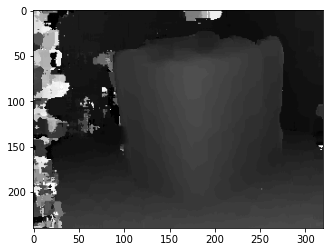

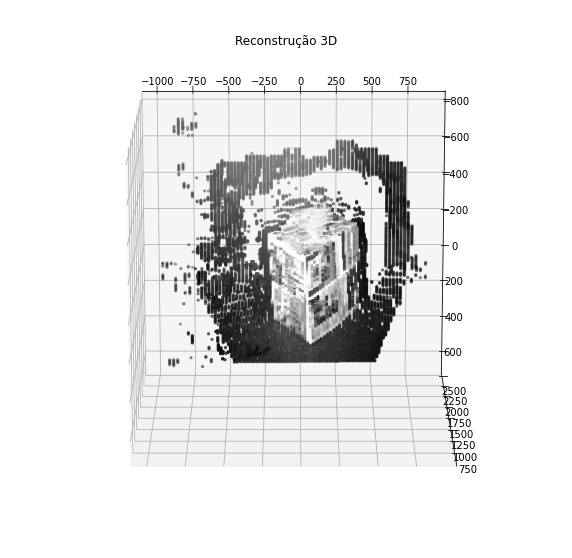

In [24]:
def main(): 
  # Params
  left_img = cv.imread('esquerda.ppm', 0)
  right_img = cv.imread('direita.ppm', 0)

  # Intrinsic parameter matrix
  fm = 403.657593  # Focal distance in pixels
  cx = 161.644318  # Principal point - x-coordinate (pixels)
  cy = 124.202080  # Principal point - y-coordinate (pixels)
  bl = 119.929  # baseline (mm)

  K = np.array([
      [fm, 0, cx],
      [0, fm, cy],
      [0, 0, 1]
  ])

  # Obtain the correspondent points
  left_pts, right_pts = obtain_correspondent_points(
      left_img=left_img,
      right_img=right_img
  )

  # Obtain the disparity map
  disparity = plane_sweep_ncc(left_img, right_img, start=20, steps=60, wid=16)

  print('Mapa de disparidade entre as imagens retificadas:\n',disparity)

  plt.imshow(disparity, 'gray')
  plt.show()

  # Calculate depth
  m, n = left_img.shape
  Z = np.zeros((m, n))
  for i in range(m):
      for j in range(n):
          if disparity[i, j] == 0:
              # Consider Z = inf for points that were not defined in the depthmap and are filled with zero
              Z[i, j] = np.inf
          else:
              Z[i, j] = (bl * fm) / disparity[i, j]

  # Prepare points to be 3D plotted
  inv_K = np.linalg.inv(K)
  X, Y = np.meshgrid(np.arange(n), np.arange(m))
  X = np.reshape(X, m * n)
  Y = np.reshape(Y, m * n)
  Z = np.reshape(Z, m * n)
  U = np.ones((3, len(X)))
  U[0, :] = X
  U[1, :] = Y

  for i in range(Z.size):
      U[:, i] = Z[i] * np.dot(inv_K, U[:, i])

  Xl = U[0, :]
  Yl = U[1, :]
  Zl = U[2, :]

  # Select just the estimated depth
  estimated = (np.isinf(Z) == False)

  # Recover the image color
  pixel_color = []
  for i in range(X.shape[0]):
      pixel_color.append(left_img[int(Y[i]), int(X[i])])

  pixel_color = np.asarray(pixel_color)

  # Show points in a 3D plot with the recovered depth 
  fig = plt.figure(figsize=(10,10))
  ax1 = fig.gca(projection='3d')
  plt.title('Reconstrução 3D')
  ax1.scatter3D(
      Xl[estimated][0:-1:5],
      Yl[estimated][0:-1:5],
      Zl[estimated][0:-1:5],
      c=pixel_color[estimated][0:-1:5] / 255.0,
      marker='.',
      cmap='gray'
  )

  ax1.view_init(elev=-75, azim=-90)
  plt.show()
#------------------------------------------------------------------------------------------------------------------
if __name__ == '__main__':
  main()
 